In [1]:
using LinearAlgebra

In [2]:
using CSV
using DataFrames

In [3]:
df = CSV.read("ParticleEnergies.csv", DataFrame)

Row,NumParticles,Energy
,Int64,Float64
1,2,0.5
2,3,1.73205
3,4,3.67423
4,5,6.47469
5,6,9.98528
6,7,14.453
7,8,19.6753
8,9,25.76
9,10,32.7169


### Energy Function to Optimize
$$f(X) = \sum_{i \neq j} \frac{1}{||x_i - x_j||^2}$$
$$||x_i|| = ||x_j|| = 1$$

In [4]:
function potential_energy(X)
    # Compute the potential energy of the particle configuration
    n = size(X,2)
    energy = 0.0
    for i in 1:n-1
        for j in i+1:n
            r = norm(X[:,i] - X[:,j])
            energy += 1 / r
        end
    end
    return energy
end

potential_energy (generic function with 1 method)

In [5]:
function easier_potential_energy(X)
    # Compute the easier potential energy of the particle configuration
    n = size(X,2)
    energy = 0.0
    for i in 1:n-1
        for j in i+1:n
            r = norm(X[:,i] - X[:,j])
            energy += 1 / r^2
        end
    end
    return energy
end

easier_potential_energy (generic function with 1 method)

### Gradient of Energy Function
$$g(X) = \nabla f(X)$$
$$\frac{\partial f}{\partial x_i} = \sum_{j \neq i} \frac{-2(x_i - x_j)}{||x_i - x_j||^4}$$
$$\frac{\partial f}{\partial x_j} = \sum_{i \neq j} \frac{2(x_i - x_j)}{||x_i - x_j||^4}$$
$$||x_i|| = ||x_j|| = 1$$

In [6]:
function gradient(X)
    # Compute the gradient of the potential energy
    k = size(X,1)
    n = size(X,2)
    G = zeros(k, n)
    for i in 1:n-1
        for j in i+1:n
            z = X[:,i] - X[:,j]
            r = norm(z)
            G[:,i] += -2*z / r^4
            G[:,j] += 2*z / r^4
        end
    end
    return G
end

gradient (generic function with 1 method)

### Gradient Check Code
Using the source code from Lecture 31

In [7]:
"""
    gradient_check(f, x, g)

Check that g seems to express the gradient of f by comparing
values computed with finite differences. This is based on the 
gradientcheck function in the Poblano Matlab toolbox.
"""
function gradient_check(f, x, g)
    fx = f(x) # computed function 
    gx = g(x) # putative gradient
    
    h = sqrt(eps(fx))
    xi = copy(x)
    gxd = copy(gx) 
    for i=1:length(x)
        xi[i] += h
        gxd[i] = (f(xi) - fx)/h
        xi[i] = x[i] # reset
    end
    absdiff = abs.(gxd .- gx)
    
    return (g=gx, gfd=gxd, maxdiff=maximum(absdiff), normdiff=norm(gxd - gx))
end

gradient_check

In [8]:
x = [0 1; 1 1; 1 0]
x = x ./ sqrt.(sum(x.^2, dims=1))
gradient_check(easier_potential_energy, x, gradient).maxdiff

2.0500248831822887e-8

### Gradient Descent Algorithm
$$X_{k+1} = X_k - \alpha g(X_k)$$
$$||X_k|| = 1$$

In [9]:
function gradient_descent(X::Matrix, alpha::Float64, tol::Float64, max_iter::Int)
    # X = initial point
    # alpha = step size
    # tol = tolerance for convergence
    # max_iter = maximum number of iterations
    iter = 0
    prev_energy = potential_energy(X)
    while iter < max_iter
        G = gradient(X)
        X -= alpha .* G
        X = X ./ sqrt.(sum(X.^2, dims=1)) # re-normalize positions
        
        current_energy = easier_potential_energy(X)
        if abs(current_energy - prev_energy) < tol
            print("Converged in ", iter, " iterations\n")
            break
        end
        prev_energy = current_energy
        iter += 1
    end
    
    return X
end

gradient_descent (generic function with 1 method)

### Thompson Problem
Implementation of the Thompson Problem using gradient descent, and a initial random point $X_0$

In [10]:
function random_thomson_problem(k::Int, n::Int, alpha::Float64, tol::Float64, max_iter::Int)
    # Initialize particle positions randomly on the unit sphere
    X = randn(k, n)
    X = X ./ sqrt.(sum(X.^2, dims=1))

    # Gradient Descent
    X = gradient_descent(X, alpha, tol, max_iter)
    
    return X
end

random_thomson_problem (generic function with 1 method)

Implementation of the Thompson Problem using GD and a given initial point $X_0$

In [11]:
function thomson_problem(X::Matrix, alpha::Float64, tol::Float64, max_iter::Int)
    X = X ./ sqrt.(sum(X.^2, dims=1))
    
    X = gradient_descent(X, alpha, tol, max_iter)
    
    return X
end

thomson_problem (generic function with 1 method)

### Plotting the Unit Sphere with 

In [12]:
using Plots

function plot_sphere(points::Matrix, title::String)
    # Define sphere meshgrid
    b = range(0, 2π, length=50)
    a = range(0, π, length=50)
    x = cos.(b) * sin.(a)'
    y = sin.(b) * sin.(a)'
    z = ones(length(b)) * cos.(a)'

    # Create plot of sphere
    p = plot(
        x, y, z, seriestype=:surface, color=:lightgrey, opacity=0.8,
        xlabel="x", ylabel="y", zlabel="z",
        title=title
    )

    # Add the points
    scatter!(
        points[1, :], points[2, :], points[3, :],
        markersize=5, color=:red, label="Points"
    )

    # Add lines connecting the points
    for i in 1:size(points, 2)
        for j in i+1:size(points, 2)
            plot!(
                [points[1, i], points[1, j]],
                [points[2, i], points[2, j]],
                [points[3, i], points[3, j]],
                color=:black, linewidth=2, linestyle=:solid, label=""
            )
        end
    end

    # Set camera and axis properties for interactivity
    plot!(p, camera=(30, 30), aspect_ratio=:equal)
    plot!(p, xlims=(-1, 1), ylims=(-1, 1), zlims=(-1, 1))
    plot!(p, legend=:bottomleft)

    return p
end

plot_sphere (generic function with 1 method)

### Some Results
$k=3, n=2$ to test the functions. That is, a 3D Sphere with just 2 particles.

In [13]:
X = random_thomson_problem(3,2, 0.01, 0.0, 10000)
fx = potential_energy(X)
efx = easier_potential_energy(X)
gx = gradient(X)
print("\nEnergy: ", fx, "\nEasier Energy: ", efx, "\nGrad: ", norm(gx), "\nX1: ", X[:,1], "\nX2: ", X[:,2])


Energy: 0.5
Easier Energy: 0.25
Grad: 0.35355339059327373
X1: [-0.48697505609532094, 0.6065378398651725, -0.6284641147692122]
X2: [0.48697505608432995, -0.606537839861112, 0.6284641147816474]

In [14]:
X0 = [0 0; 0.5 1; 0.3 -1]
X = thomson_problem(X0, 0.01,1e-10,6000)
fx = potential_energy(X)
efx = easier_potential_energy(X)
gx = gradient(X)
print("\nEnergy: ", fx, "\nEasier Energy: ", efx, "\nGrad: ", norm(gx), "\nX1: ", X[:,1], "\nX2: ", X[:,2])

Converged in 3052 iterations

Energy: 0.5000000199032988
Easier Energy: 0.25000001990329923
Grad: 0.35355343281454804
X1: [0.0, 0.12246330287297993, 0.9924730421776908]
X2: [0.0, -0.12190321479102963, -0.9925419921714204]

### Initial point is already a solution

In [15]:
X = [0.0 0.0; 1 -1; 0.0 0.0]
fx = potential_energy(X)
efx = easier_potential_energy(X)
gx = gradient(X)
print("\nEnergy: ", fx, "\nEasier Energy: ", efx, "\nGrad: ", norm(gx), "\nX1: ", X[:,1], "\nX2: ", X[:,2])


Energy: 0.5
Easier Energy: 0.25
Grad: 0.3535533905932738
X1: [0.0, 1.0, 0.0]
X2: [0.0, -1.0, 0.0]

### Problems with N > 2

Converged in 1223 iterations

Energy: 1.7320508139692772
Easier Energy: 1.0000000073921478
Grad: 1.1547005511865283

X1: [0.7191079871798036, -0.4508538050313937, -0.5287859200687224]
X2: [0.2219489523372294, 0.7855685535060631, 0.5775990913244219]
X3: [-0.9411021320705883, -0.3345519417852338, -0.049007910177054255]

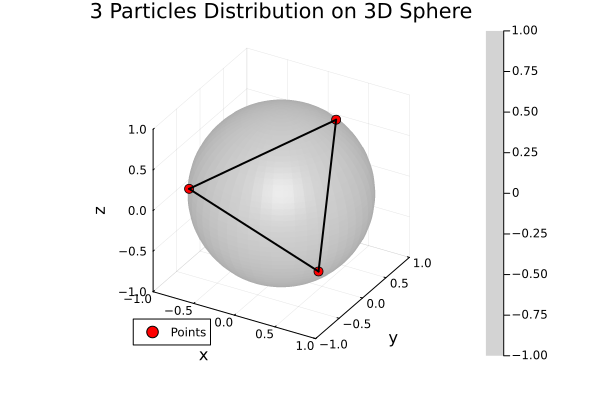

In [16]:
X = random_thomson_problem(3,3, 0.01, 1e-10, 10000)
fx = potential_energy(X)
efx = easier_potential_energy(X)
gx = gradient(X)
print("\nEnergy: ", fx, "\nEasier Energy: ", efx, "\nGrad: ", norm(gx))
print("\n\nX1: ",X[:,1], "\nX2: ", X[:,2], "\nX3: ", X[:,3])
p = plot_sphere(X, "3 Particles Distribution on 3D Sphere")
display(p)

Converged in 781 iterations

Energy: 3.6742346168517095
Easier Energy: 2.2500000043556003
Grad: 2.2500000065570536

X1: [0.9937612526957964, 0.09193855293095245, 0.06313378751068045]
X2: [-0.2291868603133712, -0.9087502495707965, -0.34877839234206315]
X3: [-0.3604468180591148, 0.6959865846253077, -0.6210320163829389]
X4: [-0.4041372244612281, 0.12081188041140503, 0.9066849471322636]

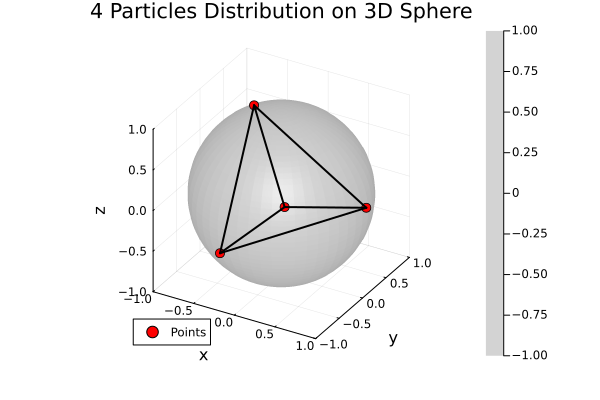

In [17]:
X = random_thomson_problem(3,4, 0.01, 1e-10, 10000)
fx = potential_energy(X)
efx = easier_potential_energy(X)
gx = gradient(X)
print("\nEnergy: ", fx, "\nEasier Energy: ", efx, "\nGrad: ", norm(gx))
print("\n\nX1: ",X[:,1], "\nX2: ", X[:,2], "\nX3: ", X[:,3], "\nX4: ", X[:,4])
p = plot_sphere(X, "4 Particles Distribution on 3D Sphere")
display(p)

Converged in 3714 iterations

Energy: 6.474691501650353
Easier Energy: 4.250000011670114
Grad: 3.802411527231569

X1: [-0.8228433467458239, -0.21346594675080635, 0.5266508485646954]
X2: [-0.30897381823321496, -0.6098183851140343, -0.7298333486648165]
X3: [-0.2584856004250179, 0.9659373938136963, -0.012253391584453167]
X4: [0.5675946158647713, -0.35620385405351235, 0.7422635424151901]
X5: [0.8227407984052879, 0.21353030274204515, -0.5267849546544774]

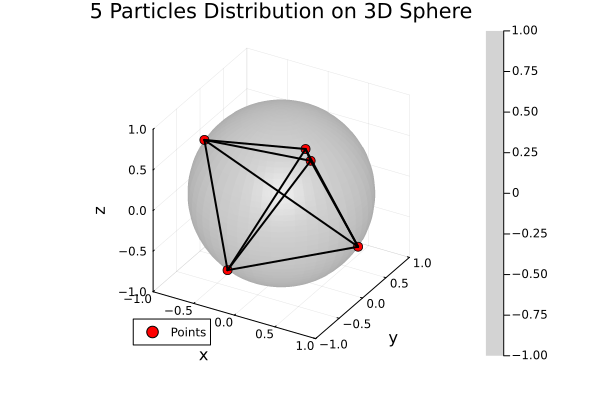

In [18]:
X = random_thomson_problem(3,5, 0.01, 1e-10, 10000)
fx = potential_energy(X)
efx = easier_potential_energy(X)
gx = gradient(X)
print("\nEnergy: ", fx, "\nEasier Energy: ", efx, "\nGrad: ", norm(gx))
print("\n\nX1: ",X[:,1], "\nX2: ", X[:,2], "\nX3: ", X[:,3] ,"\nX4: ", X[:,4], "\nX5: ", X[:,5])
p = plot_sphere(X, "5 Particles Distribution on 3D Sphere")
display(p)

### General Function

In [19]:
function solveRandomThompson(k::Int, n::Int, alpha::Float64, tol::Float64, max_iter::Int)
    X = random_thomson_problem(k,n,alpha,tol,max_iter)
    
    fx = potential_energy(X)
    efx = easier_potential_energy(X)
    gx = gradient(X)
    
    print("\nEasier Energy: ", efx, "\nGrad: ", norm(gx))
    if n < 6
        print("\n")
        for particle in range(1,n)
            print("\nX" * string(particle) * ": ", X[:,particle])
        end
    end
    
    if k == 3 && n in df.NumParticles
        real_energy = df[only(findall(==(n), df.NumParticles)), :].Energy
        print("\n\nTrue Energy: ", real_energy, "\nObtained Energy: ", fx)
        print("\nError with true value: ", abs(real_energy - fx))

        p = plot_sphere(X, string(n) * " Particles Distribution in 3D Sphere")
        display(p)
    end
end

solveRandomThompson (generic function with 1 method)

Converged in 1878 iterations

Easier Energy: 4.2500000116604495
Grad: 3.8024115272218695

X1: [0.3960191605756136, -0.7712282361296089, -0.4983731857287256]
X2: [-0.6412121317405561, -0.6207976153782369, 0.4510624378613526]
X3: [-0.39597794269932435, 0.7711482081828225, 0.49852974827188906]
X4: [0.8898994860558717, 0.1884623706912062, 0.415404428901457]
X5: [-0.2487416937688199, 0.43244075219775474, -0.8666732750117881]

True Energy: 6.474691495
Obtained Energy: 6.474691501644587
Error with true value: 6.644587102755395e-9

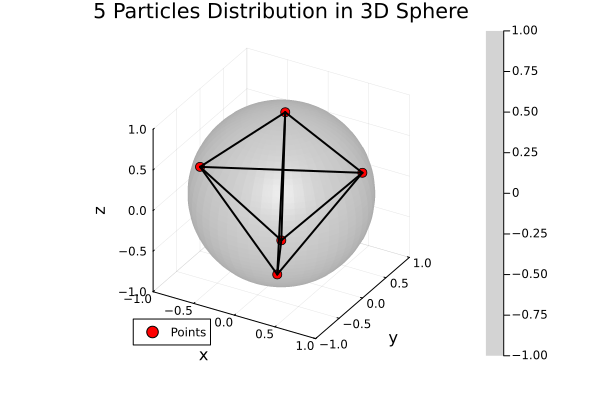

In [22]:
solveRandomThompson(3,5,0.01,1e-10,10000)


Easier Energy: 2863.8578321552914
Grad: 13237.471611311017

True Energy: 1287.772720783
Obtained Energy: 1485.1598131026449
Error with true value: 197.3870923196448

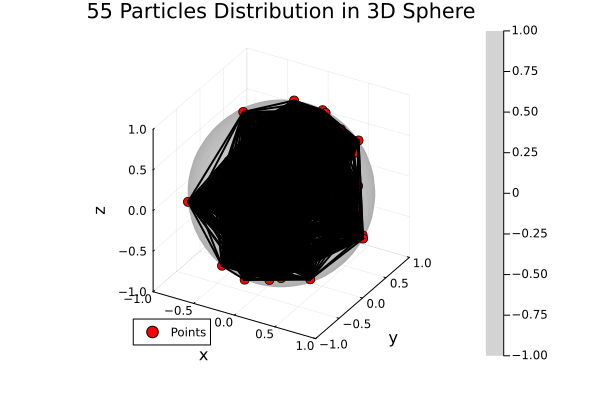

In [20]:
solveRandomThompson(3,55,0.01,1e-10,10000)


Easier Energy: 20364.50394330313
Grad: 3.128994978104874e6

True Energy: 4448.350634331
Obtained Energy: 4961.368568736412
Error with true value: 513.0179344054122

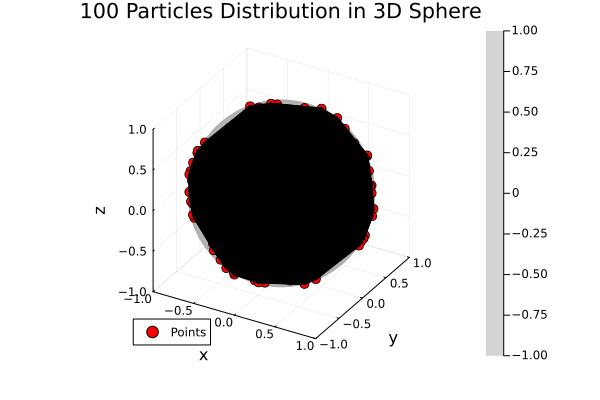

In [21]:
solveRandomThompson(3,100,0.01,1e-10,10000)